# Script to preprocess the ETH/UCY dataset
Assuming that the dataset is locally available

In [138]:
import collections
import functools
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow_graphics.geometry import transformation
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [139]:
def _list_dir(path):
  files = os.listdir(path)
  return files

def _agents_pos_to_ragged_tensor(agents_df):
  """
  Converts agent's positional data fom pandas dataframe to a dictionary of ragged tensors
  """
  tensor_dict = collections.defaultdict(dict)
  for i, df in agents_df.groupby('id'):
    dropped_df = df.droplevel(1, axis=0)
    r_tensor = tf.RaggedTensor.from_value_rowids(
        values=np.vstack(df['p'].values).flatten().astype(np.float32),
        value_rowids=np.tile(np.array(dropped_df.index),
                             (2, 1)).transpose().flatten())
    r_tensor = r_tensor.to_list()
    r_tensor = [x for x in r_tensor if len(x)>0]
    tensor_dict[i] = {'positions': np.asarray(r_tensor),
                      'poses': np.zeros([len(r_tensor), 17,3])}
  new_df = pd.DataFrame.from_dict(tensor_dict, orient='index')
  return new_df


def _load_scene(f):
  """
  Loads and processes positional data from one scene (so one recording)
  """
  pos_df = pd.read_csv(
      f, header=None, delimiter='\t', names=['timestep', 'id', 'x', 'y'])
  pos_df.timestep = pos_df.timestep.astype(int) // 10
  pos_df.timestep = pos_df.timestep - pos_df.timestep.min()
  pos_df.id = pos_df.id.astype(int)
  pos_df = pos_df.set_index(['timestep', 'id']).apply(
      lambda x: pd.Series({'p': np.array(x)}), axis=1)
  pos_ragged = _agents_pos_to_ragged_tensor(pos_df)
  return pos_ragged

  

def load_train_dataset(path, dataset):
    """
    loads the training dataset by loading the different scenes and combining the data
    """
    num_history_steps = 5
    num_steps = 15
    num_agents = 1
    scene_count = 0
    new_ds = None
    files = _list_dir(
        os.path.join(path, dataset, 'val'))
    files = [
        os.path.join(path, dataset, 'val', f)
        for f in files
    ]
    for f in files:
        scene_dataset = _load_scene(f)
        if scene_count == 0:
          new_ds = scene_dataset
          scene_count += 1
        else:
           new_ds = pd.concat([new_ds, scene_dataset], axis=0)

    
    return new_ds

scenes = ['eth', 'hotel', 'univ', 'zara1', 'zara2']
count = 0
new_ds = None
for s in scenes:
  ds = load_train_dataset("/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/Trajectron-plus-plus/experiments/pedestrians/raw", s)
  if count == 0:
    new_ds = ds
    count += 1
  else:
      new_ds = pd.concat([new_ds, ds], axis=0)

new_ds

,positions,poses
142,"[[9.195220947265625, 10.609621047973633], [9.5...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
169,"[[11.329968452453613, 11.791703224182129], [11...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
176,"[[3.5265533924102783, 12.17260456085205], [3.2...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
177,"[[3.263892889022827, 11.683351516723633], [2.9...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
178,"[[14.022448539733887, 7.1342573165893555], [14...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
416,"[[1.6299999952316284, 1.6799999475479126], [1....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
417,"[[3.7100000381469727, -0.949999988079071], [3....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
418,"[[3.7100000381469727, -4.820000171661377], [3....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
419,"[[3.369999885559082, -9.710000038146973], [3.3...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [140]:
def get_augmented_train_pickle(df):
    """
    Augments the data by randomly rotating and translating it and combining it with the original data
    """
    df=df.reset_index(drop=True)
    def random_rotate(df):
        augmented_df = pd.DataFrame(columns=['positions', 'poses'])

        for i,row in df.iterrows():
            yaw = np.random.uniform(-np.pi/4, np.pi/4)
            
            # Create rotation matrix for the yaw angle
            cos_yaw = np.cos(yaw)
            sin_yaw = np.sin(yaw)
            rot_mat = np.array([
                [cos_yaw, -sin_yaw],
                [sin_yaw,  cos_yaw]
            ])

            augmented_df.loc[i] = [np.dot(row['positions'], rot_mat.T), row['poses']]
        return augmented_df

    def random_translate(df):
        augmented_df = pd.DataFrame(columns=['positions', 'poses'])

        for i,row in df.iterrows():
            translation = np.random.uniform(-1.0, 1.0, 2)            
            
            augmented_df.loc[i] = [row['positions'] + translation, row['poses']]

        return augmented_df

    new_df = random_rotate(df)
    new_df = random_translate(new_df)

    aug_df = pd.concat([df, new_df], ignore_index=True)

    aug_df.to_pickle('df_eth_augmented_val.pkl')

get_augmented_train_pickle(new_ds)

In [128]:
counter = 0
for i, row in new_ds.iterrows():
    if row['positions'].shape[0] > 15:
        counter +=1
counter

5627

In [132]:
new_ds.to_pickle('df_eth.pkl')

In [130]:
ds.iloc[0]['positions']

array([[ 1.40999997, -5.67999983],
       [ 1.27999997, -6.3499999 ]])

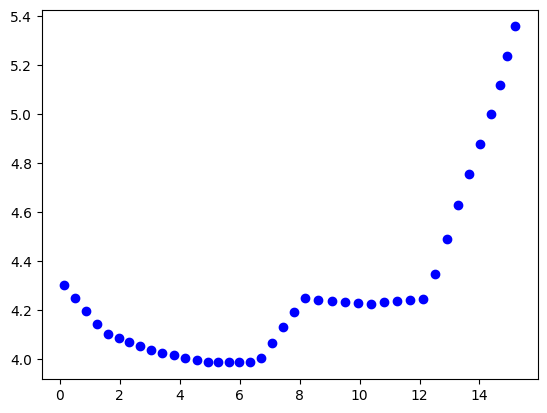

In [122]:
plt.plot(ds.iloc[450]['positions'][:,0], ds.iloc[450]['positions'][:,1], 'bo')
plt.show()
